

## **Showcase: Non-linear regression with neural networks**
---
### **Authors**
Ryan Tuckman - rxt224@psu.edu (B.S. at Penn State University Park | Computer Science)

Sahil Kuwadia - szk6258@psu.edu (B.S. at Penn State University Park | Computer Science)

Rabah Abdul Khalek - khalek@jlab.org (Postdoc at JLab | Theory division)  

Alexei Prokudin - prokudin@psu.edu (Professor of Physics at Penn State Berks)

<a target="_blank" href="https://github.com/prokudin/PHYS496-Fall2024/tree/main/Tutorials/PHYS496_Fall_2024_(4)_PyTorch_Nonlinear_Regression_with_NN_improved.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### **Learning Goals**

This notebook will serve as an introduction to non-linear regression using neural networks. We will learn how to build and train neural networks with PyTorch, a powerful machine learning library.




---




## **Overview**

In this tutorial, we will be working with the [Gluon dataset](https://github.com/rabah-khalek/TF_tutorials/tree/master/PseudoData). A gluon is an elementary particle which gives rise to the strong force, which is the force responsible for binding together the protons and neutrons together in atomic nuclei.

The gluon is exchanged by other elementary particles in the proton and neutron called quarks. These quarks and gluons are more generally referred to as "partons".

Because of certain physical properties governing the partons, they cannot be observed by expermiments as free particles, and their distribution within the proton and neutron cannot be calculated analytically. Instead, their distribution must be inferred from data collected by high energy particle colliders like the Large Hadron Collider (LHC) at CERN.

A fast-moving proton can be described by the parton distribution function (PDF) $f(x)$, which gives the probability density of finding a parton of type $f$ (a specific quark type or gluon) carrying a fraction $x$ of the proton momentum.

The pseudodata used in this tutorial is generated from a gluon distribution function $g(x)$, which was determined in an analysis by the [NNPDF collaboration](http://nnpdf.mi.infn.it), aiming to extract the structure of the proton using contemporary machine learning methods. More specifically, NNPDF determines PDFs using neural networks as a minimally biased modeling tool, trained using Genetic Algorithms (and more recently stochastic gradient descent).

We will consider this pseudodata to be the *truth* that we're trying to *discover*. What we will actually fit is the *smeared truth*, where Gaussian noise is added to simulate more realistic data.


### Imports:
- **PyTorch Libraries**: Core libraries for building and optimizing neural networks, and managing data loading.
- **Pandas**: A popular data analysis library to load and manipulate datasets.
- **Matplotlib**: A plotting library used to visualize data, which will be helpful for plotting loss curves or visualizing predictions.

This imports cell sets up the tools you'll need for loading data, building models, training, and visualizing results.


In [1]:
# Imports necessary libraries

# PyTorch core libraries
import torch  # Provides core functionalities for tensors and computation on GPU
import torch.nn as nn  # Helps in building neural networks by providing layers and modules
import torch.optim as optim  # Provides optimization algorithms such as Adam, SGD

# PyTorch utilities for handling datasets
from torch.utils.data import Dataset, TensorDataset, DataLoader
# Dataset: Abstract class for all datasets
# TensorDataset: Wraps tensors into a dataset object
# DataLoader: Loads data in batches for training or testing

# Pandas for data manipulation
import pandas as pd  # Provides data structures like DataFrame for handling tabular data
# Numpy
import numpy as np

# Matplotlib for visualization
import matplotlib.pyplot as plt  # Used for plotting graphs and visualizing data

- **Google Colab Mounting**: This is specific to Google Colab, where you need to mount your Google Drive in order to access files stored in your Drive. This is useful for loading datasets or saving models, figures, etc.
- **Path `/content/drive`**: Once mounted, your Drive files will be accessible under this directory, allowing you to read data or save models directly from/to your Google Drive.


In [2]:
#@title Google colab mounting
# Mount Google Drive to access data and save files in the Colab environment

from google.colab import drive  # Import Colab-specific library to mount Google Drive
drive.mount('/content/drive')  # Mount Google Drive at the specified path '/content/drive'


Mounted at /content/drive


## **Importing the Gluon data set with Pandas**

There are four separate datasets each containing a total of 1000 gluon PDF predictions computed between $x=[x_{min},1]$; where:
- $x_{min} = 10^{-3}$ for `filename1`
- $x_{min} = 10^{-4}$ for `filename2`
- $x_{min} = 10^{-5}$ for `filename3`
- $x_{min} = 10^{-6}$ for `filename4`
  
Below we use `pandas` to import all datapoints from text files. We then use `sklearn` to split the data randomly into 800 points for training and 200 points for testing.

In [3]:
!git clone https://github.com/prokudin/PHYS496-Fall2024.git

Cloning into 'PHYS496-Fall2024'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 89 (delta 12), reused 14 (delta 6), pack-reused 60 (from 1)
Receiving objects: 100% (89/89), 47.82 MiB | 27.38 MiB/s, done.
Resolving deltas: 100% (25/25), done.


### Explanation:
- **`filename1`**: This specifies the path to the file that contains the data you want to load. It’s important that this path points to the correct location in the Colab environment.
- **`lines_to_skip`**: The number of rows to skip in the file before starting to read the actual data (this often skips headers or comments).
- **`columns`**: This names the columns you want to assign to the dataset for clarity.
  - `"x"`: Represents some variable (likely momentum fraction in this case).
  - `"gluon_cv"`: The central value of the gluon distribution.
  - `"gluon_sd"`: The standard deviation (uncertainty) associated with the gluon central value.
- **`pd.read_csv`**: Reads the data from the file into a pandas DataFrame.
  - `sep="\s+"`: The data is space-separated.
  - `usecols=[0, 1, 2]`: Only read the first three columns from the file.
  - `names=columns`: Assign the names `"x"`, `"gluon_cv"`, and `"gluon_sd"` to the corresponding columns in the DataFrame.

After this, you will have a DataFrame (`df`) containing the data from the file, which you can use for further analysis or to feed into your neural network.


In [4]:
# Path to the dataset (change this path if necessary)
filename1 = './PHYS496-Fall2024/Tutorials/data/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-3.dat'
filename2 = './PHYS496-Fall2024/Tutorials/data/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-4.dat'
filename3 = './PHYS496-Fall2024/Tutorials/data/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-5.dat'
filename4 = './PHYS496-Fall2024/Tutorials/data/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-6.dat'

# Headers to skip (usually metadata or column labels in the file)
lines_to_skip = 5  # Skipping the first 5 lines which contain metadata

# Defining the columns (cv = central value, sd = standard deviation)
columns = ["x", "gluon_cv", "gluon_sd"]  # Columns represent x, gluon central value, and gluon standard deviation

# Read the data from the file and create a pandas DataFrame
df = pd.read_csv(filename1,
                 sep="\s+",  # The separator is whitespace
                 skiprows=lines_to_skip,  # Skip the first 5 lines
                 usecols=[0, 1, 2],  # Only use the first three columns (x, cv, sd)
                 names=columns)  # Name the columns as defined above



### Explanation:
- **`df.copy()`**: This creates a deep copy of the DataFrame `df` to ensure that the original data remains unchanged. All modifications will be applied to `df_all`.
- **`np.random.seed(42)`**: Setting a seed for NumPy's random number generator ensures that the random noise added to the data will be the same each time the code is run. This is important for reproducibility.
- **Adding Noise**:
  - Noise is added to the `"gluon_cv"` column using `np.random.normal(0, df_all['gluon_sd'])`.
  - This generates random values from a normal distribution with a mean of `0` and a standard deviation given by the values in the `"gluon_sd"` column.
  - The noise is added element-wise to each value in the `"gluon_cv"` column, simulating the uncertainty described by `"gluon_sd"`.

This step introduces variability into the central values, mimicking real-world scenarios where data is subject to measurement uncertainty.

Let me know when you're ready to move on to the next cell!

In [5]:
# Make a copy of the original DataFrame to avoid altering the original data
df_all = df.copy()

# Add noise to the 'gluon_cv' column
# Setting a random seed for reproducibility
np.random.seed(42)

# Add Gaussian noise to the central values ('gluon_cv')
# The noise is generated using a normal distribution with mean 0 and standard deviation from 'gluon_sd'
df_all['gluon_cv'] += np.random.normal(0, df_all['gluon_sd'])

This cell splits the data into two datasets 80% for training, 20% for testing. Please, find a way to do this directly in pytorch


### Explanation:
- **`random_split`**: This function splits the dataset randomly into two subsets based on the sizes provided. In this case, it splits `df_all` into a training set (`df_train`) and a testing/validation set (`df_test`).
- **Training Size**: `train_size = int(0.8 * len(df_all))` calculates 80% of the total number of data points for training.
- **Validation Size**: `val_size = len(df_all) - train_size` computes the remaining 20% of the data to be used for testing or validation.
- **Purpose of Split**: Splitting the data is crucial for model evaluation. Training data is used to train the model, and testing/validation data is used to evaluate its performance on unseen data to prevent overfitting.

In [6]:
# Import random_split from PyTorch to split datasets into training and testing sets
from torch.utils.data import random_split

# Determine the size of the training set (80% of the total data) and validation/test set (20%)
train_size = int(0.8 * len(df_all))  # 80% of the dataset for training
val_size = len(df_all) - train_size  # The rest 20% for validation/testing

# Split the dataset into training and testing sets using random_split
# df_train will contain 80% of the data and df_test will contain 20%
df_train, df_test = random_split(df_all, [train_size, val_size])



### Explanation:
- **Function Purpose**: This function plots the training and testing data with error bars, showing both the central values and the uncertainties (standard deviations).
- **`plt.subplots(1, 2, figsize=(10, 3))`**: Creates a figure with 1 row and 2 columns of subplots, where the left plot will show the training data and the right plot will show the testing data.
- **Plotting Training Data**:
  - `ax[0].errorbar()`: This plots the data for the training set. The central values (`gluon_cv`) are multiplied by `x` to show the product `x * g(x)`. The error bars represent the uncertainty (`gluon_sd`).
  - `color='b'` (blue): Specifies the color for the training data plot.
  - The Y-axis limits are set to a fixed range (-0.05 to 0.4) to ensure consistent scaling.
- **Plotting Testing Data**:
  - Similar to the training data plot, but uses `color='r'` (red) to differentiate the test data.
  - The same Y-axis limits are applied to ensure that the visual comparison between the two plots is meaningful.
  
This function is useful for visualizing the behavior of the training and testing data to understand how they differ before model training.


In [7]:
def createTrainTestPlots(train, test):
    """
    Plots the data from the train and test sets.

    :param train: DataFrame with keys in ["x", "gluon_cv", "gluon_sd"] for the training data.
    :param test: DataFrame with keys in ["x", "gluon_cv", "gluon_sd"] for the testing data.
    """

    # Create a figure with 1 row and 2 subplots, with a defined figure size
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))

    # Plot the training data (Left plot)
    ax[0].axhline(0, color='k', linewidth=0.5)  # Draw a horizontal line at y=0 for reference
    ax[0].errorbar(train['x'], train['x']*train['gluon_cv'], train['gluon_sd'],
                   fmt='.', color='b', alpha=0.5)  # Error bar plot for train data
    ax[0].set_title("Train data")  # Title for the train data plot
    ax[0].set_xlabel("x")  # X-axis label
    ax[0].set_ylabel("x g(x)")  # Y-axis label
    ax[0].set_ylim(-0.05, 0.4)  # Set limits for the Y-axis

    # Plot the testing data (Right plot)
    ax[1].axhline(0, color='k', linewidth=0.5)  # Draw a horizontal line at y=0 for reference
    ax[1].errorbar(test['x'], test['x']*test['gluon_cv'], test['gluon_sd'],
                   fmt='.', color='r', alpha=0.5)  # Error bar plot for test data
    ax[1].set_title("Test data")  # Title for the test data plot
    ax[1].set_xlabel("x")  # X-axis label
    ax[1].set_ylabel("g(x)")  # Y-axis label
    ax[1].set_ylim(-0.05, 0.4)  # Set limits for the Y-axis

    # Display the plots
    plt.show()


### Explanation:
- **`df_train.dataset`** and **`df_test.dataset`**:
  - Since `random_split` returns instances of `torch.utils.data.Dataset`, `df_train.dataset` and `df_test.dataset` will contain the training and testing data respectively.
  - The function expects data in the form of a DataFrame with keys `["x", "gluon_cv", "gluon_sd"]`, which is compatible with the DataFrame format you used earlier.

- **`createTrainTestPlots`**: This function takes the two datasets and creates side-by-side plots of the training and testing data. It will display the product `x * g(x)` for both the training and testing datasets with error bars.

If you run this cell, it should output two plots:
1. **Train data**: A scatter plot of the training data (`x * gluon_cv`) with error bars (`gluon_sd`).
2. **Test data**: A scatter plot of the testing data (`x * gluon_cv`) with error bars (`gluon_sd`).


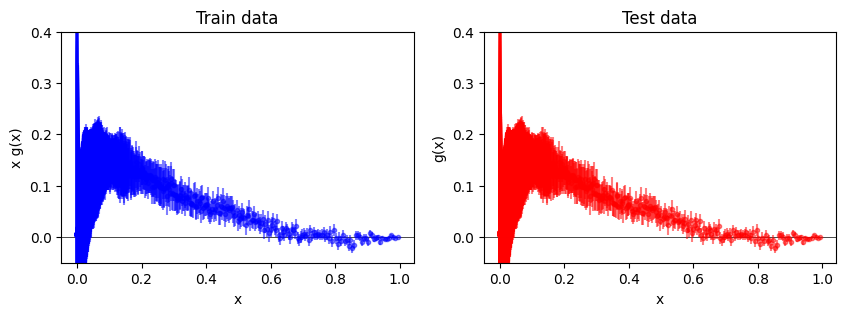

In [ ]:
createTrainTestPlots(df_train.dataset, df_test.dataset)

## **Building a Neural Network using PyTorch**

The idea here is to fit the gluon distribution (which cannot be calculated analytically) using a neural network.

We will build the neural network of 1 input, 1 hidden layer, and 1 output.

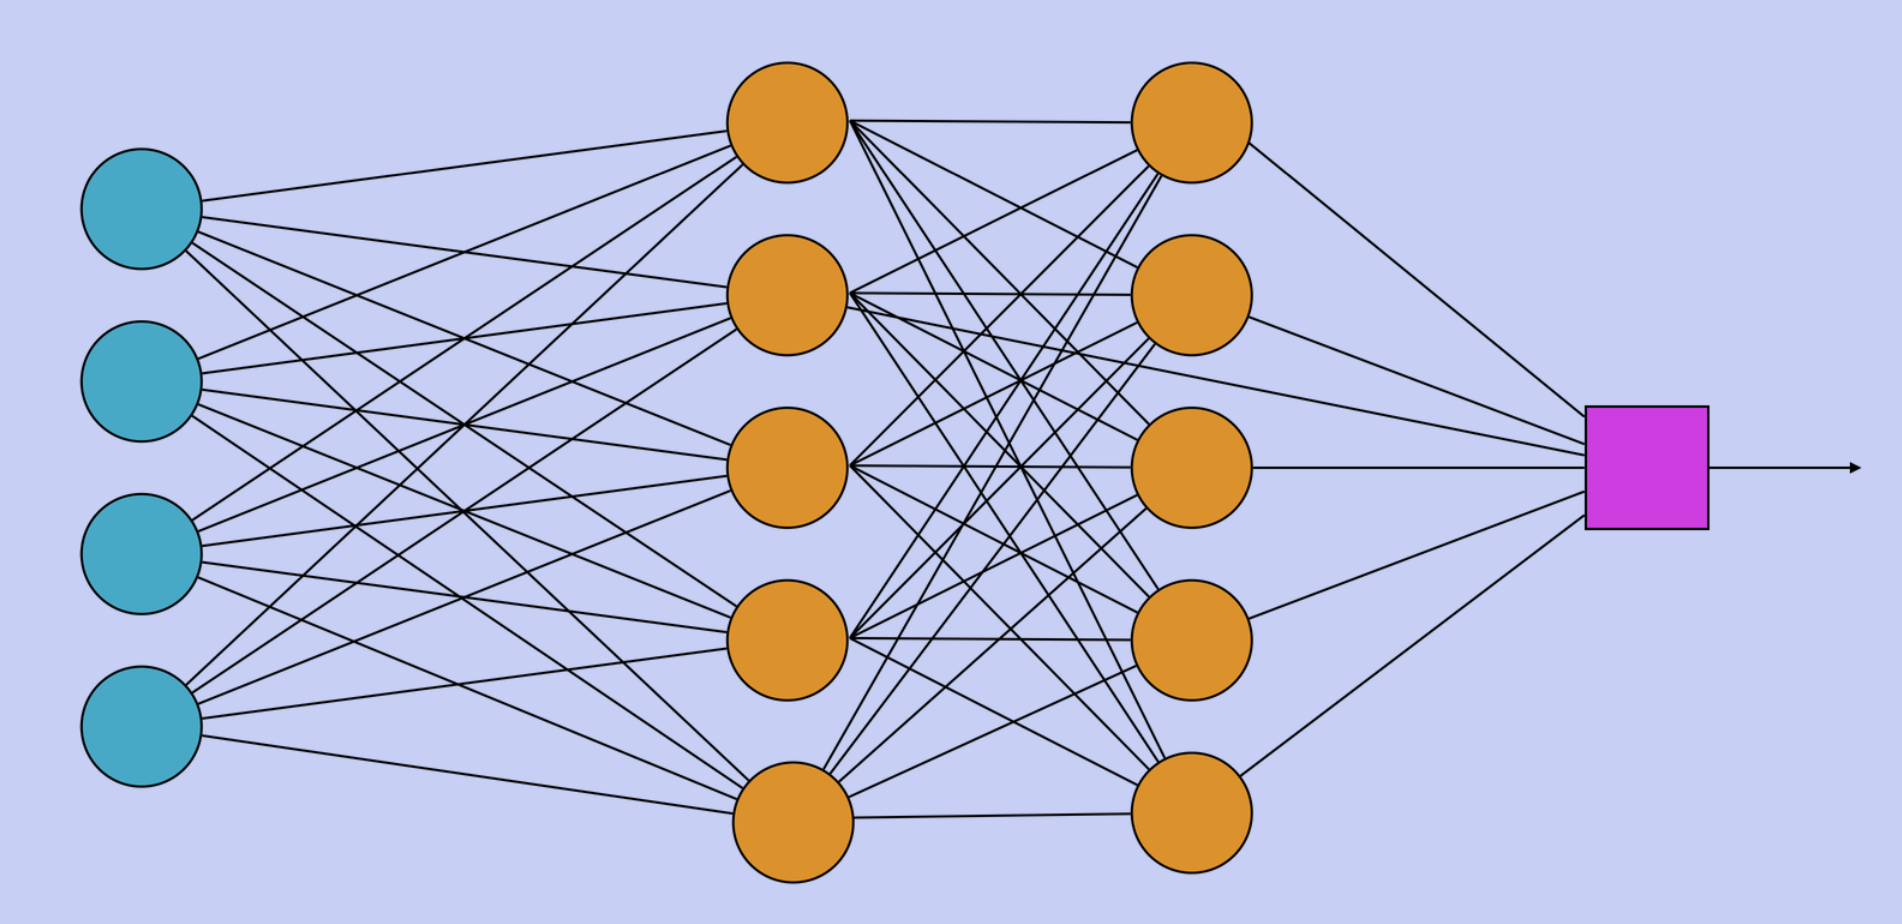

We consider a single layered neural network to be sufficient for our exercise here, but feel free to experiment with *deeper* architectures.

For regression tasks, a few key adjustments can be made to your code to ensure it works effectively:

### Key Adjustments for Regression:

1. **Output Layer Activation**:
   - For regression, you typically do **not** apply any activation function at the output layer. You want the output to be continuous, and adding a non-linear activation (like Sigmoid or Softmax) would constrain the output to a specific range, which is not suitable for regression.
   
2. **Loss Function**:
   - Ensure you are using an appropriate loss function for regression, like **Mean Squared Error (MSE)** or **Mean Absolute Error (MAE)**. This is defined outside the model during training.

3. **Normalization**:
   - Normalizing input features (like you're doing with `nn.functional.normalize(x)`) is often a good practice in regression. However, instead of L2 normalization, **standardization** (scaling features to zero mean and unit variance) might be more effective depending on your data.

4. **No Final Activation Function**:
   - Since you are working with regression, the final layer should not have any activation function, so your output can take on any value (positive or negative).


### Explanation:
- **`torch.cuda.is_available()`**: Checks whether CUDA (the GPU computing platform in PyTorch) is available on your machine. If a compatible GPU is available, it returns `True`, otherwise `False`.
- **`torch.device('cuda' if torch.cuda.is_available() else 'cpu')`**:
  - If a GPU is available (`torch.cuda.is_available()` returns `True`), the device is set to `"cuda"`, which means the model will be trained on the GPU.
  - If no GPU is available, it defaults to `"cpu"`, which means the model will be trained on the CPU.

This device setting will be used later in your code to ensure that the model and data are sent to the correct hardware (CPU or GPU).




In [8]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [9]:
# Updated Hyperparameters
n_features = 1              # Number of input features remains the same
n_neurons_1 = 8             # Increased number of neurons in the first hidden layer
n_neurons_2 = 16            # Increased number of neurons in the second hidden layer
n_outputs = 1               # Output features remain the same for regression
learning_rate = 0.01        # Reduced learning rate for finer adjustments
batch_size = 128            # Increased batch size for more stable gradient updates
n_epochs = 1000             # Increased epochs for more training cycles

### Explanation:
1. **Input Data Preparation**:
   - **`torch.tensor(...).float().to(device)`**:
     - This converts the training and testing data from pandas DataFrames into PyTorch tensors and moves them to the appropriate device (GPU or CPU).
     - `.float()` ensures the data type is `float32`, which is necessary for model training in PyTorch.
     - We need a vector-column, so we do `.reshape(-1, 1)`. It takes an array amnd makes a vector colunm.
     - `.to(device)` moves the tensors to the correct hardware (either GPU or CPU) based on the earlier device setting.

2. **TensorDataset**:
   - **`TensorDataset`**: Combines the input features (`x_train` or `x_test`), the target values (`y_train` or `y_test`), and uncertainties (`dy_train` or `dy_test`) into a single dataset that can be used by a `DataLoader`. This allows batching the data for training and evaluation.

3. **DataLoader**:
   - **`DataLoader`**: This object efficiently loads batches of data for training or testing. The `batch_size=batch_size` argument specifies how many samples to include in each batch.
   - **`shuffle=True`**: This ensures that the dataset is shuffled at each epoch during training, which helps with model generalization. For testing, you typically don't need to shuffle.

### Next Steps:
- The data is now prepared and loaded into batches, ready for the neural network to process during training and testing.
- You can now proceed to define the model architecture or continue with other preprocessing steps.

In [10]:
# Prepare training data
# Convert data to PyTorch tensors and move to the specified device (CPU/GPU)
x_train = torch.tensor(df_train.dataset['x'].values.reshape(-1, 1)).float().to(device)    # Input features (x)
y_train = torch.tensor(df_train.dataset['gluon_cv'].values.reshape(-1, 1)).float().to(device) # Target values (gluon_cv)
dy_train = torch.tensor(df_train.dataset['gluon_sd'].values.reshape(-1, 1)).float().to(device) # Standard deviation (gluon_sd)

# Create a TensorDataset, which holds the input features (x_train), targets (y_train), and uncertainties (dy_train)
train_dataset = TensorDataset(x_train, y_train, dy_train)

# Create a DataLoader for the training dataset, which will handle batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Prepare testing data (similar to training data)
x_test = torch.tensor(df_test.dataset['x'].values.reshape(-1, 1)).float().to(device)    # Input features (x)
y_test = torch.tensor(df_test.dataset['gluon_cv'].values.reshape(-1, 1)).float().to(device)  # Target values (gluon_cv)
dy_test = torch.tensor(df_test.dataset['gluon_sd'].values.reshape(-1, 1)).float().to(device)  # Standard deviation (gluon_sd)

# Create a TensorDataset for the test set
test_dataset = TensorDataset(x_test, y_test, dy_test)

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)




### Explanation:
- **Model Class**: The `Torch_Model_New` class inherits from `nn.Module`, which is the base class for all PyTorch models. This means we can easily build a custom neural network architecture by overriding the `__init__` and `forward` methods.
  
#### The `__init__` Method:
- **`nn.Linear`**:
  - This represents a fully connected (dense) layer. The first argument is the number of input features, and the second argument is the number of neurons (units) in the layer.
  - For instance, `nn.Linear(n_features, n_neurons1)` creates a layer that maps the input features to `n_neurons1` units in the first hidden layer.
- **`nn.ReLU()`**:
  - ReLU (Rectified Linear Unit) is an activation function applied after each hidden layer. It introduces non-linearity to the model, allowing it to learn more complex relationships.
- **`n_outputs`**:
  - For regression tasks, the output layer does not have any activation function (no non-linearity), which allows the model to output continuous values.

#### The `forward` Method:
- This method defines the forward pass of the model. It takes an input tensor `x` and passes it sequentially through the layers.
  - First, the input is passed through `fc1` and `relu1` (first hidden layer).
  - Then it’s passed through `fc2` and `relu2` (second hidden layer).
  - Finally, it’s passed through `fc3` to produce the output.

### Next Steps:
1. **Model Instantiation**: You can now instantiate the model with the desired hyperparameters (e.g., `n_features`, `n_neurons1`, `n_neurons2`, `n_outputs`).
2. **Model Training**: Once instantiated, you can train the model using the training data prepared earlier.
3. **Prediction**: After training, the model can be used to make predictions on new data.


In [11]:
import torch
import torch.nn as nn

class Torch_Model_New(nn.Module):
    def __init__(self, n_features, n_neurons1, n_neurons2, n_outputs):
        """
        Define the architecture of the neural network model.

        :param n_features: Number of input features (for example, 1 in this case).
        :param n_neurons1: Number of neurons in the first hidden layer.
        :param n_neurons2: Number of neurons in the second hidden layer.
        :param n_outputs: Number of output neurons (usually 1 for regression).
        """
        super().__init__()

        # Define the first fully connected layer (input layer to first hidden layer)
        self.fc1 = nn.Linear(n_features, n_neurons1)  # Hidden Layer 1 (input features to first hidden layer)
        self.relu1 = nn.ReLU()  # ReLU activation for hidden layers

        # Define the second fully connected layer (first hidden layer to second hidden layer)
        self.fc2 = nn.Linear(n_neurons1, n_neurons2)  # Hidden Layer 2
        self.relu2 = nn.ReLU()  # ReLU activation for hidden layers

        # Define the final fully connected layer (second hidden layer to output)
        self.fc3 = nn.Linear(n_neurons2, n_outputs)  # Output Layer (no activation function for regression)

    def forward(self, x):
        """
        Forward pass of the network.

        :param x: Input tensor (of shape [batch_size, n_features]).
        :returns: Output tensor (of shape [batch_size, n_outputs]).
        """
        # Pass input through the first hidden layer and apply ReLU activation
        out = self.fc1(x)
        out = self.relu1(out)  # Apply ReLU activation

        # Pass through the second hidden layer and apply ReLU activation
        out = self.fc2(out)
        out = self.relu2(out)  # Apply ReLU activation

        # Pass through the output layer (no activation function for regression)
        out = self.fc3(out)

        return out



## **Data modeling and fitting**

### **Chi-square**

One of the most frequently occurring problems in high-energy physics is to compare an observed distribution with a prediction, for example from a simulation. Indeed, an analysis might be designed to extract some physical parameter from the simulation or prediction which best fits the data.  

For data points with Gaussian errors, the likelihood of a gaussian distribution is:

$$ L = \prod_i \frac{1}{\sqrt(2\pi\sigma^2)} e^{-\frac{(m_i - d_i)^2}{2\sigma_i^2}}$$

hence the following [MLE](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) (maximum (log) likelihood estimation) gives:

$$ \chi^2 = \sum_i^N \left(\frac{m_i - d_i}{\sigma_i} \right)^2$$

where $m_i$ is the model evaluated at point $x_i$, $d_i$ is the data, and $\sigma_i$ is the uncertainty on the data at this point.

The chi-square expresses the deviation of the observed data from the fit, weighted inversely by the uncertainties in the individual points. The chi-square can be either used to test how well a particular model describes the data or, if the prediction is a function of some parameters then the optimal values of the parameters can be found by minimizing the chi-square.

The main pitfall here is that the purely Gaussian case is in fact rather rare, usually because the data points come from Poisson-distributed numbers of events which are not well approximated by Gaussian distributions. Using a standard chi-square approach in such cases leads to biased estimates of both the parameters and their uncertainties.

Nevertheless we will assume here that our datapoints' errors are Gaussian, and we will use the chi-square as the loss function in this tutorial.

## Explanation:
For each data point, the chi-square loss is defined as:
[ \chi^2 = \sum_i \left( \frac{y_{\text{true},i} - y_{\text{pred},i}}{\sigma_i} \right)^2 ]
Where:
( y_{\text{true},i} ) is the true value for the (i)-th data point.
( y_{\text{pred},i} ) is the predicted value for the (i)-th data point.
( \sigma_i ) is the uncertainty (or standard deviation) associated with the (i)-th data point.
The goal of the chi-square loss function is to minimize the sum of squared differences between the true and predicted values, weighted by the uncertainties.

1. **Inheritance from `nn.Module`**:
   - The `ChiSquareLoss` class inherits from `nn.Module`, allowing it to integrate smoothly into the PyTorch ecosystem. This makes it compatible with other PyTorch functions, such as optimizers or model training loops.

2. **`__init__` Method**:
   - This method is necessary to initialize the class and pass control to the base class (`nn.Module`).
   - No parameters are required here, as the loss function doesn't have learnable parameters.

3. **`forward` Method**:
   - This method defines how the loss is computed during the forward pass.
   - The **Chi-Square loss** is computed by comparing the predicted values (`y_pred`) to the true values (`y_true`) using the formula:
     \[
     \chi^2 = \frac{1}{N} \sum \left( \frac{(y_{\text{true}} - y_{\text{pred}})}{\sigma} \right)^2
     \]
     Where:
     - \( y_{\text{true}} \) is the true target value,
     - \( y_{\text{pred}} \) is the predicted value,
     - \( \sigma \) is the uncertainty (standard deviation) associated with each true value.
   - The result is averaged across the batch with `torch.mean()`.

### When to Use Chi-Square Loss:
- **Chi-Square loss** is especially useful when your target values have associated uncertainties (standard deviations) that you want to account for during the training of the model. In physics, this is often used for fitting data where measurement errors are present, and smaller deviations are penalized less if the uncertainty is high.
  
- This loss function allows the model to give more weight to points with smaller uncertainty (i.e., smaller `sigma` values), making it suitable for scenarios where uncertainty is important in determining the quality of the fit.




In [12]:
class ChiSquareLoss(nn.Module):
    def __init__(self):
        """
        Initialize the Chi-Square loss class, inheriting from nn.Module.
        This will allow us to use it like any other PyTorch loss function.
        """
        super().__init__()

    def forward(self, y_pred, y_true, dy_true):
        """
        Forward pass of the custom Chi-Square loss function.

        :param y_pred: Predicted values from the model (tensor of shape [batch_size, n_outputs]).
        :param y_true: True values or target values (tensor of shape [batch_size, n_outputs]).
        :param dy_true: Standard deviation of the true values (tensor of shape [batch_size, n_outputs]).

        :return: Computed chi-square loss (scalar tensor).
        """
        # Compute the chi-square loss as the mean of ( (y_true - y_pred) / sigma )^2
        loss = torch.mean(((y_true - y_pred) / dy_true) ** 2)
        return loss


### Function to Plot Training Progress and Predictions

Here’s an explanation of the function `plot_graphs1`:

#### Purpose:
- This function is designed to:
  1. Plot the training loss over epochs (in logarithmic scale).
  2. Compare the model's predictions with the true test set values, showcasing the model's performance on unseen data.



### Explanation:

1. **Plot 1: Training Loss (Logarithmic Plot)**
    - `plt.plot(np.log(train_losses), label='Train Loss')`: The training loss is plotted in log scale. Taking the log of the loss values helps compress large loss variations, making the training progress easier to interpret.
    - `plt.xlabel('Epoch')`: The x-axis corresponds to the epoch number.
    - `plt.ylabel('Log(Loss)')`: The y-axis is the logarithm of the loss value.
    - `plt.legend()`: A label for the plot is added.

2. **Plot 2: Model Predictions vs True Test Values**
    - **Test Set Evaluation:**
      - `model.eval()`: This puts the model in evaluation mode, disabling behaviors like dropout or batch normalization (if they exist). This is important when evaluating the performance of the model on test data.
      - `y_pred = model(x_test)`: Passes the test inputs (`x_test`) through the model to get predictions (`y_pred`).
    - **Plotting Predictions and True Values:**
      - `plt.plot(x_test.cpu().numpy(), y_test.cpu().numpy(), label='True Values')`: Plots the true test values (`y_test`) against the test input `x_test`.
      - `plt.plot(x_test.cpu().numpy(), y_pred.detach().cpu().numpy(), label='Predictions')`: Plots the predicted values (`y_pred`) against the same test inputs.
    - **Logarithmic Scale for x-axis:**
      - `plt.xscale('log')`: The x-axis is set to a logarithmic scale. This is useful when the input values (`x_test`) span a large range, and it helps in visualizing trends across a broad range.
    - `plt.xlabel('x')` and `plt.ylabel('Gluon PDF')`: Labels for the x and y axes, respectively.
    - `plt.legend()`: Adds a legend to the graph to distinguish between the true values and the model predictions.
    - `plt.show()`: Finally, this displays the plot.


### Summary of what this function does:
- **Training loss** is plotted logarithmically, allowing you to track how well the model is improving.
- **Predictions vs True Values**: After every epoch, the model's performance on the test set is visualized by comparing its predictions to the actual test values.

Let me know if you'd like to dive deeper into any of the sections!

In [13]:
def plot_graphs1(epoch, train_losses, test_losses, model, x_test, y_test, dy_test):
    """
    Function to plot the training loss over epochs and the model predictions on the test data.

    :param epoch: Current epoch (used in the training process, not directly used in the plots).
    :param train_losses: A list of training losses for each epoch.
    :param model: The PyTorch model that has been trained.
    :param x_test: Input data for the test set (tensor).
    :param y_test: True values (targets) for the test set (tensor).
    :param y_test: Errors on the true values (targets) for the test set (tensor).
    """

    # Plot 1: Training Loss (in log scale)
    plt.figure(figsize=(6, 4))
    # Plot the log of the training losses to better visualize the loss progression.
    plt.plot(np.log(train_losses), label='Train Loss')
    plt.plot(np.log(test_losses), label='Test Loss')
    plt.xlabel('Epoch')  # X-axis is the epoch number
    plt.ylabel('Log(Loss)')  # Y-axis is the log of the training loss
    plt.legend()  # Add a legend
    plt.show()

    # Plot 2: Predictions vs True Values
    plt.figure(figsize=(6, 4))

    # Set model to evaluation mode to disable dropout or batch norm (if any)
    model.eval()

    # Get model predictions on the test set
    y_pred = model(x_test)

    # Plot the true test values
    plt.errorbar(x_test.cpu().numpy(), y_test.cpu().numpy().flatten(), yerr=dy_test.cpu().numpy().flatten(), fmt='.', color='darkblue', label='Test data', alpha=0.1)

    # Plot the model predictions
    plt.plot(x_test.cpu().numpy(), y_pred.detach().cpu().numpy(), label='Predictions', color='red')

    # Set the x-axis scale to log for better visualization of large range of x values
    plt.xscale('log')

    # Add labels to the axes
    plt.xlabel('x')
    plt.ylabel('Gluon PDF')

    # Add legend to the plot
    plt.legend()

    # Display the plot
    plt.show()


Let us create a plotting of batches of data ans predictions of the model

In [14]:
def plot_graphs2(model, x_test, y_test, dy_test):
    """
    Function to plot the model predictions on the test data.

    :param model: The PyTorch model that has been trained.
    :param x_test: Input data for the test set (tensor).
    :param y_test: True values (targets) for the test set (tensor).
    :param y_test: Errors on the true values (targets) for the test set (tensor).
    """


    # Plot 1: Predictions vs True Values
    plt.figure(figsize=(6, 4))

    # Generate 100 points
    x = 10**np.linspace(-3,0,100, dtype="float32").reshape(-1,1)

    # Set model to evaluation mode to disable dropout or batch norm (if any)
    model.eval()

    # Get model predictions on those 100 points
    y_pred = model(torch.tensor(x))

    # Plot the true test values
    plt.errorbar(x_test.cpu().numpy(), y_test.cpu().numpy().flatten(), yerr=dy_test.cpu().numpy().flatten(), fmt='.', color='tab:green', label='Batch of the training data', alpha=0.5)

    # Plot the model predictions
    plt.plot(x, y_pred.detach().cpu().numpy(), label='Predictions', color='red')

    # Set the x-axis scale to log for better visualization of large range of x values
    plt.xscale('log')

    # Add labels to the axes
    plt.xlabel('x')
    plt.ylabel('Gluon PDF')

    # Add legend to the plot
    plt.legend()

    # Display the plot
    plt.show()


Epoch [1/1600], Loss: 528.4429473876953


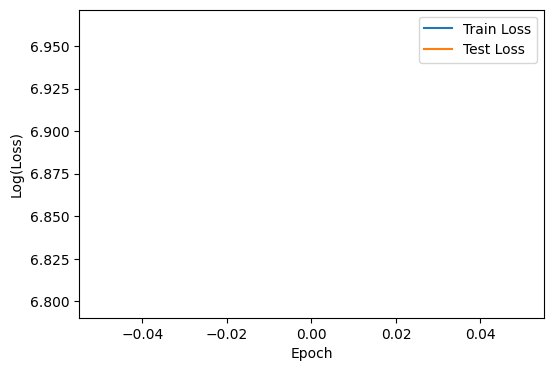

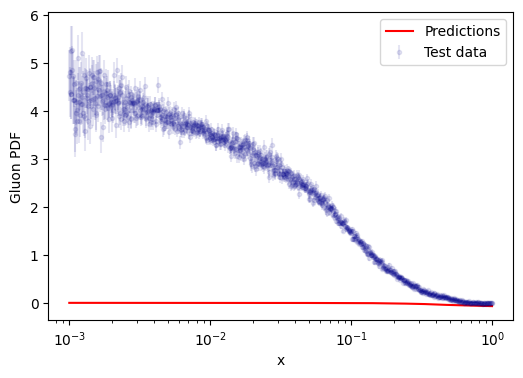

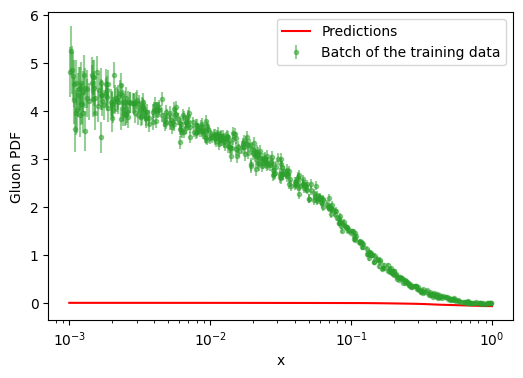

Epoch [401/1600], Loss: 5.746058702468872


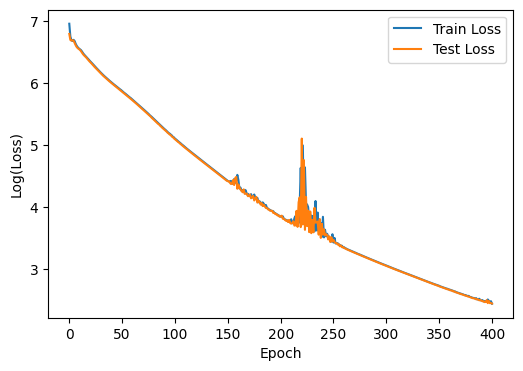

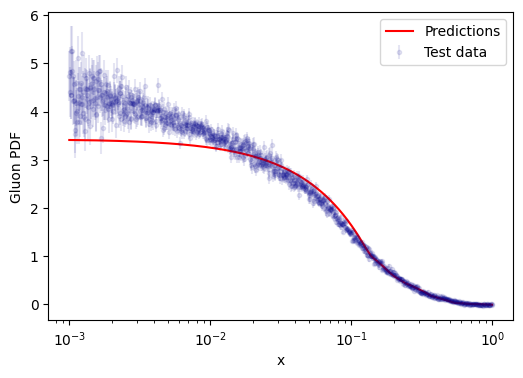

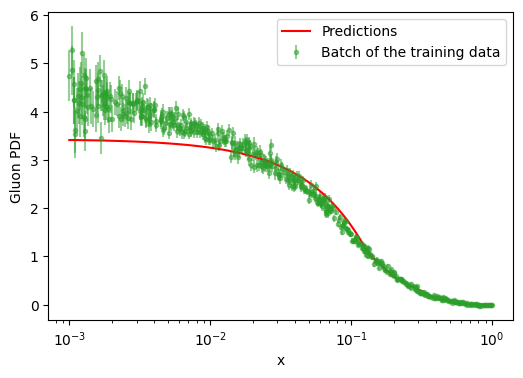

Epoch [801/1600], Loss: 2.3926650285720825


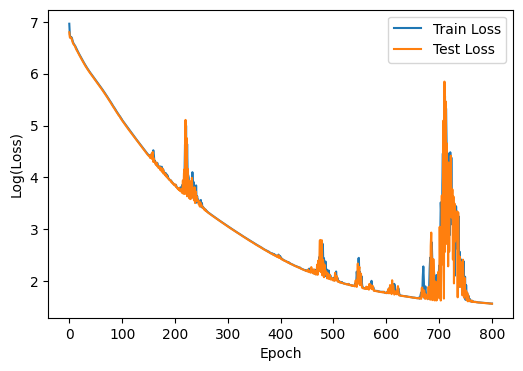

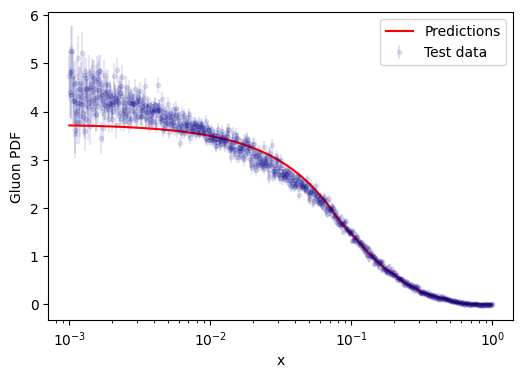

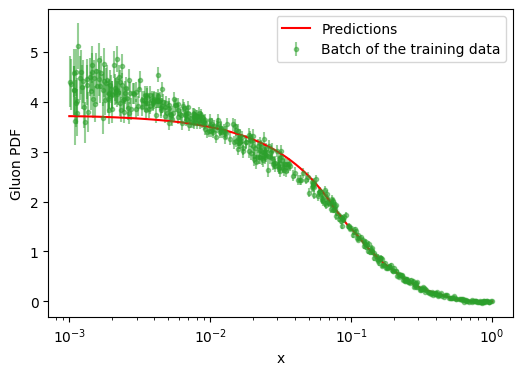

Epoch [1201/1600], Loss: 2.252796709537506


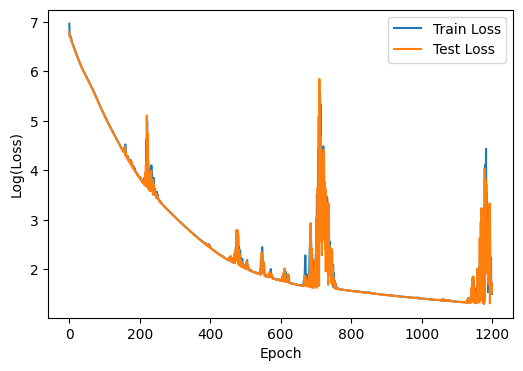

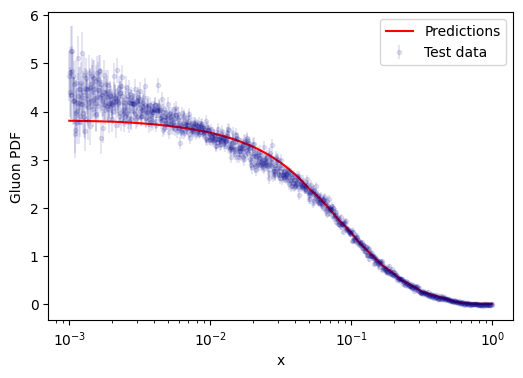

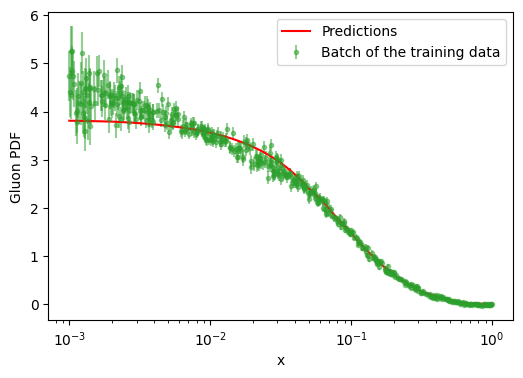

Epoch [1600/1600], Loss: 1.7176010608673096


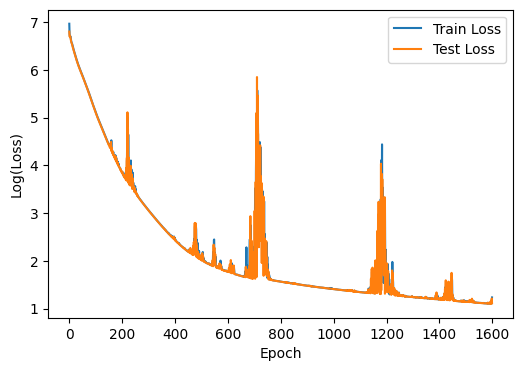

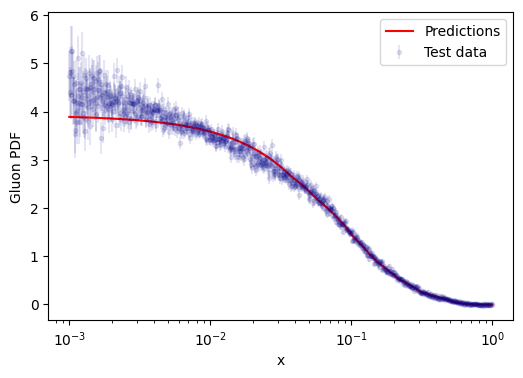

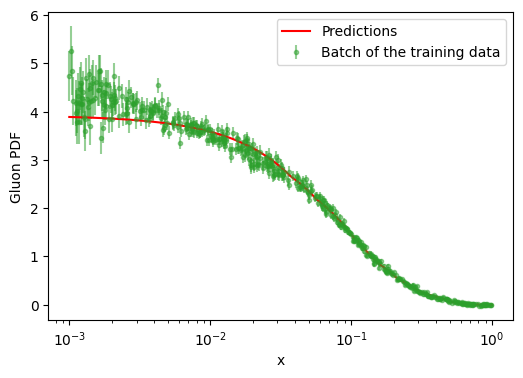

In [16]:
# Updated Hyperparameters for Enhanced Model
n_features = 1              # Number of input features remains the same
n_neurons_1 = 64            # Neurons in the first hidden layer
n_neurons_2 = 32            # Neurons in the second hidden layer
n_neurons_3 = 16            # Additional third hidden layer for greater depth
n_outputs = 1               # Output features remain the same for regression
learning_rate = 0.001       # Reduced learning rate for stable updates
batch_size = 500            # Large batch size for stable gradient updates
n_epochs = 1600             # High epoch count with potential for early stopping
dropout_rate = 0.2          # Dropout rate to prevent overfitting



# We need to recreate a DataLoader for the training dataset, which will handle batching and shuffling
# as batch_size may become different when we explore the notebook
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# We need to recreate a a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model, more complicated compared to the test above
model = Torch_Model_New(n_features=1, n_neurons1=n_neurons_1, n_neurons2=n_neurons_2, n_outputs=1).to(device)

# Define loss function and optimizer
criterion = ChiSquareLoss()  # Mean Squared Error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



train_losses = []
test_losses = []
# Training loop
for epoch in range(n_epochs):
    model.train()  # Put the model in training mode
    running_loss = 0.0

    for x_batch, y_batch, dy_batch in train_loader:  # Note: Uncertainty (dy_train) is not used here
        # Forward pass
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch, dy_batch)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    train_losses.append(running_loss)

    # Here we alculate the losses on a test data, we do not use the data in training and hence no_grad()
    with torch.no_grad():
      model.eval() # Put the model in evaluation mode
      test_loss = 0.0
      for x_batch, y_batch, dy_batch in test_loader:
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch, dy_batch)
        test_loss += loss.item()
      test_losses.append(test_loss)

    #plot_graphs(epoch, n_epochs, train_losses, test_losses, model, x_test, y_test, df_train, dy_train)

    if epoch % 400 == 0 or epoch == n_epochs - 1 :
      print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(train_loader)}')
      plot_graphs1(epoch, train_losses, test_losses,  model,  x_test, y_test, dy_test)
      plot_graphs2(model,  x_batch, y_batch, dy_batch)


Saving the model: https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [17]:
torch.save(model,'model64x32.pth') # We save the whole model heere


In [18]:
# Read the data from the file and create a pandas DataFrame
df = pd.read_csv(filename4,
                 sep="\s+",  # The separator is whitespace
                 skiprows=lines_to_skip,  # Skip the first 5 lines
                 usecols=[0, 1, 2],  # Only use the first three columns (x, cv, sd)
                 names=columns)  # Name the columns as defined above


In [19]:
mymodel = torch.load('model64x32.pth', weights_only=False) # Load the model
mymodel.eval() # Set the model in evaluation mode

Torch_Model_New(
  (fc1): Linear(in_features=1, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [20]:
x_test1 = torch.tensor(df['x'].values.reshape(-1, 1)).float().to(device)    # Input features (x)
y_test1 = torch.tensor(df['gluon_cv'].values.reshape(-1, 1)).float().to(device)    # Input values (y)
dy_test1 = torch.tensor(df['gluon_sd'].values.reshape(-1, 1)).float().to(device)    # Input errors (dy)

In [21]:
y_prediction = mymodel(x_test1)

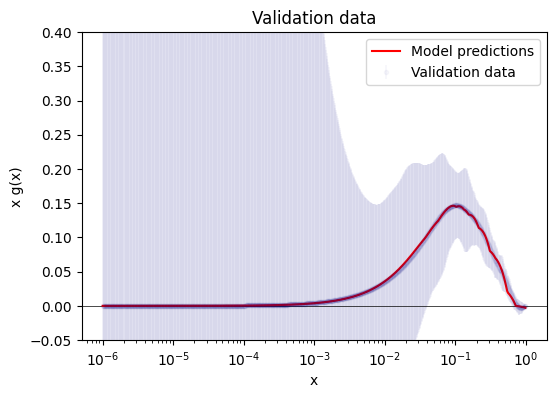

In [22]:
# Create a figure with 1 row and 2 subplots, with a defined figure size
fig, ax = plt.subplots(1, 1, figsize=(6, 4))



ax.errorbar(df['x'], df['x']*df['gluon_cv'], df['gluon_sd'], fmt='.', color='darkblue', label='Validation data', alpha=0.03) # Plot the true test values
ax.axhline(0, color='k', linewidth=0.5)  # Draw a horizontal line at y=0 for reference
ax.plot(x_test1.detach().cpu().numpy(), x_test1.detach().cpu().numpy()*y_prediction.detach().cpu().numpy(), label='Model predictions', color='red')  # Model results

ax.set_title("Validation data")  # Title for the train data plot
ax.set_xlabel("x")  # X-axis label
ax.set_ylabel("x g(x)")  # Y-axis label
ax.set_ylim(-0.05, 0.4)  # Set limits for the Y-axis
ax.legend()
ax.set_xscale('log')

In [ ]:
print(f'Loss = {criterion(y_prediction, y_test1, dy_test1)}')

Loss = 0.21432383358478546
